# Capture the Flag (RL - Policy Gradient)

- Seung Hyun Kim
- skim449@illinois.edu

## Implementation Details

- Actor-critic
- On Policy

### Sampling
- [ ] Mini-batch to update 'average' gradient
- [ ] Experience Replay for Random Sampling
- [ ] Importance Sampling
    
### Deterministic Policy Gradient
- [ ] DDPG
- [ ] MADDPG

### Stability and Reducing Variance
- [x] Gradient clipping
- [ ] Normalized Reward/Advantage
- [ ] Target Network
- [ ] TRPO
- [ ] PPO

### Multiprocessing
- [ ] Synchronous Training (A2C)
- [x] Asynchronous Training (A3C)

### Applied Training Methods:
- [ ] Self-play
- [ ] Batch Policy

## Notes

- This notebook includes:
    - Building the structure of policy driven network.
    - Training with/without render
    - Saver that save model and weights to ./model directory
    - Writer that will record some necessary datas to ./logs

- This notebook does not include:
    - Simulation with RL policy
        - The simulation can be done using policy_RL.py
    - cap_test.py is changed appropriately.
    
## References :
- https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb (source)
- https://www.youtube.com/watch?v=PDbXPBwOavc
- https://github.com/lilianweng/deep-reinforcement-learning-gym/blob/master/playground/policies/actor_critic.py (source)
- https://github.com/spro/practical-pytorch/blob/master/reinforce-gridworld/reinforce-gridworld.ipynb

## TODO:

- Research on '_bootstrap_' instead of end-reward
- Add global step
- Think about adding discont to advantage
- Normalize reward?
- Record method in network

In [1]:
!rm -rf logs/A3C_lstm/ model/A3C_lstm

In [2]:
TRAIN_NAME='A3C_lstm'
LOG_PATH='./logs/'+TRAIN_NAME
MODEL_PATH='./model/' + TRAIN_NAME

In [3]:
import os
import configparser
from tqdm import tqdm

import signal
import threading
import multiprocessing

import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.layers as layers
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import gym
import gym_cap
import gym_cap.envs.const as CONST
import numpy as np
import random
import math

# the modules that you can use to generate the policy. 
import policy.random
import policy.roomba
import policy.policy_RL
import policy.zeros

# Data Processing Module
from utility.dataModule import one_hot_encoder_v2 as one_hot_encoder
from utility.utils import MovingAverage as MA
from utility.utils import discount_rewards
from utility.buffer import Trajectory, Trajectory_buffer

from network.ActorCritic_lstm import ActorCritic as Network

%load_ext autoreload
%autoreload 2

/Users/skim0119/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Hyperparameters

In [4]:
# Importing global configuration
config = configparser.ConfigParser()
config.read('config.ini')

## Environment
action_space = config.getint('DEFAULT','ACTION_SPACE')
n_agent = config.getint('DEFAULT','NUM_AGENT')
map_size = config.getint('DEFAULT','MAP_SIZE')
vision_range = config.getint('DEFAULT','VISION_RANGE')

## Training
total_episodes = config.getint('TRAINING','TOTAL_EPISODES')
max_ep = config.getint('TRAINING','MAX_STEP')
critic_beta = config.getfloat('TRAINING', 'CRITIC_BETA')
entropy_beta = config.getfloat('TRAINING', 'ENTROPY_BETA')
gamma = config.getfloat('TRAINING', 'DISCOUNT_RATE')

decay_lr = config.getboolean('TRAINING','DECAYING_LR')
lr_a = 5e-5 # config.getfloat('TRAINING','LR_ACTOR')
lr_c = 1e-4 # config.getfloat('TRAINING','LR_CRITIC')

## Save/Summary
save_network_frequency = config.getint('TRAINING','SAVE_NETWORK_FREQ')
save_stat_frequency = config.getint('TRAINING','SAVE_STATISTICS_FREQ')
moving_average_step = config.getint('TRAINING','MOVING_AVERAGE_SIZE')

## GPU
gpu_capacity = config.getfloat('GPU_CONFIG','GPU_CAPACITY')
gpu_allowgrow = config.getboolean('GPU_CONFIG', 'GPU_ALLOWGROW')

In [5]:
# Local configuration parameters
po_transition = 100000 # Partial observable
serial_length = 1

# Env Settings
n_channel = 11
vision_dx, vision_dy = 2*vision_range+1, 2*vision_range+1
in_size = [None,vision_dx,vision_dy,n_channel]
nenv = (int) (multiprocessing.cpu_count())

# Asynch Settings
global_scope = 'global'

## Environment Setting

In [6]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    
#Create a directory to save episode playback gifs to
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)

## A3C Network Structure

![Network Structure](https://cdn-images-1.medium.com/max/1600/1*YtnGhtSAMnnHSL8PvS7t_w.png)

- Network is given in network.ActorCritic

## Environments

![Environment Interaction Diagram](https://cdn-images-1.medium.com/max/1600/1*Hzql_1t0-wwDxiz0C97AcQ.png)

In [7]:
global_rewards = MA(moving_average_step)
global_ep_rewards = MA(moving_average_step)
global_length = MA(moving_average_step)
global_succeed = MA(moving_average_step)
global_episodes = 0

# Launch the session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_capacity,
                            allow_growth=gpu_allowgrow)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
progbar = tf.keras.utils.Progbar(total_episodes,interval=1)

## Environment Unit

In [8]:
class Environment(threading.Thread):
    def __init__(self, name, global_network, sess, global_step, coord):
        super(Environment, self).__init__()
        # Initialize Environment worker
        self.env = gym.make("cap-v0").unwrapped
        self.name = name
        self.global_network = global_network
        self.sess = sess
        self.global_step = global_step
        self.coord = coord
        
        # Create AC Network for Worker
        self.local_network = Network(in_size=in_size,
                                     action_size=action_space,
                                     lr_actor=lr_a,
                                     lr_critic=lr_c,
                                     scope=self.name,
                                     #grad_clip_norm=10.0,
                                     global_step=global_step,
                                     entropy_beta=entropy_beta,
                                     sess=sess,
                                     global_network=global_ac)
        

        
    def run(self, saver, writer):
        """Override Thread.run

        Note:
            Loop to run rollout
            Include summarizing and save
        """
        self.saver = saver
        self.writer = writer
        
        global global_rewards, global_ep_rewards, global_length, global_succeed, global_episodes
        total_step = 0
        while not coord.should_stop() and global_episodes < total_episodes:
            ep_r, r, l, s, aloss, closs, etrpy = self.rollout(init_step=total_step)
            if etrpy == None:
                continue
            total_step += l
            
            global_ep_rewards.append(ep_r)
            global_rewards.append(r)
            global_length.append(l)
            global_succeed.append(s)
            
            global_episodes += 1
            self.sess.run(global_step_next)
            progbar.update(global_episodes)
            
            if global_episodes % save_stat_frequency == 0 and global_episodes != 0:
                summary = tf.Summary()
                summary.value.add(tag='Records/mean_reward', simple_value=global_rewards())
                summary.value.add(tag='Records/mean_length', simple_value=global_length())
                summary.value.add(tag='Records/mean_succeed', simple_value=global_succeed())
                summary.value.add(tag='Records/mean_episode_reward', simple_value=global_ep_rewards())
                summary.value.add(tag='summary/Entropy', simple_value=etrpy)
                summary.value.add(tag='summary/actor_loss', simple_value=aloss)
                summary.value.add(tag='summary/critic_loss', simple_value=closs)
                self.writer.add_summary(summary,global_episodes)
                #self.writer.add_summary(summary_,global_episodes)

                self.writer.flush()
                
            if global_episodes % save_network_frequency == 0 and global_episodes != 0:
                self.saver.save(self.sess, MODEL_PATH+'/ctf_policy.ckpt', global_step=global_episodes)
                
    
    def get_action(self, states, rnn_states):
        """Run graph to get action

        Args:
            state (list): list of state for each agent
            rnn_states (list): list of rnn inputs for each agent

        Returns:
            action (list) : The action for each egent
            values (list) : The value for each action for each agent
            rnn_next (list) : List of next rnn state for each agent

        Note:
            If rnn_states=None, get action without rnn_states.
        """
        actions, values = [], []
        final_states = []
        for state, rnn_state in zip(states, rnn_states):
            action, value, final_state = self.local_network.feed_forward(
                state=state[np.newaxis,np.newaxis,:],
                rnn_init_state=rnn_state
                )
            actions.append(action[0])
            values.append(value[0])
            final_states.append(final_state)
        return actions, values, final_states
            
    def rollout(self, init_step=0):
        total_step = init_step
        with self.sess.as_default(), self.sess.graph.as_default():
            # Initialize run
            s1 = self.env.reset(map_size=map_size, 
                                policy_red=policy.zeros.PolicyGen(self.env.get_map,
                                                                  self.env.get_team_red))
            if po_transition < global_episodes:
                s1 = one_hot_encoder(s1, self.env.get_team_blue, vision_range)
            else:
                s1 = one_hot_encoder(self.env._env, self.env.get_team_blue, vision_range)

            # parameters 
            ep_r = 0 # Episodic Reward
            prev_r = 0
            step = 0
            d = False
            
            # Trajectory Buffers
            trajs = [Trajectory(depth=5) for _ in range(n_agent)]

            # RNN Initialize (If lstm is off, it will remain as list of None)
            rnn_states_serial = [tuple([] for _ in range(self.local_network.rnn_num_layers)) for _ in range(n_agent)]
            rnn_states = [self.local_network.get_lstm_initial() for _ in range(n_agent)]

            # Bootstrap
            a1, v1, final_states = self.get_action(s1, rnn_states)
            is_alive = [ag.isAlive for ag in self.env.get_team_blue]
            
            while step <= max_ep and not d:
                a, v0 = a1, v1
                s0 = s1
                was_alive = is_alive
                rnn_states = final_states

                s1, rc, d, _ = self.env.step(a)
                is_alive = [ag.isAlive for ag in self.env.get_team_blue]
                if po_transition < global_episodes:
                    s1 = one_hot_encoder(s1, self.env.get_team_blue, vision_range)
                else:
                    s1 = one_hot_encoder(self.env._env, self.env.get_team_blue, vision_range)

                r = rc - prev_r - 0.5
                if step == max_ep and d == False:
                    r = -100
                    rc = -100
                    d = True

                r /= 100.0
                ep_r += r

                if d:
                    v1 = [0.0 for _ in range(len(self.env.get_team_blue))]
                else:
                    a1, v1, final_states = self.get_action(s1, rnn_states)

                # push to buffer
                for idx, agent in enumerate(self.env.get_team_blue):
                    if was_alive[idx]:
                        trajs[idx].append([s0[idx],
                                           a[idx],
                                           r,
                                           v0[idx],
                                           0
                                          ])
                        for i in range(self.local_network.rnn_num_layers):
                            rnn_states_serial[idx][i].append(rnn_states[idx][i][0])

                # Iteration
                prev_r = rc
                total_step += 1
                step += 1
                
            replay_buffer = Trajectory_buffer(depth=5)
            trim_init_states = tuple([] for _ in range(self.local_network.rnn_num_layers))
            seq_lens = []
            
            for idx, traj in enumerate(trajs):
                if len(traj)<=serial_length:
                    continue
                else:
                    traj_length = len(traj)
                    batch_length = traj_length // serial_length

                # Discount Reward
                _rew = np.array(traj[2])
                _val = np.array(traj[3]+[v1[idx]])  # Bootstrap
                _td = _rew + gamma * _val[1:]
                _adv = _td - _val[:-1]
                traj[3] = _td.tolist()
                traj[4] = discount_rewards(_adv, gamma).tolist()
                                                   
                # Trim rnn states
                ss = 0 if traj_length % serial_length == 0 else 1
                rnn_init_state = rnn_states_serial[idx]
                trim_init_state = tuple(rnn_init_state[i][::serial_length][ss:] for i in range(self.local_network.rnn_num_layers))

                # Sequence length
                seq_len = [serial_length]*(batch_length)

                # Trim batch for each trajectory
                traj_list = traj.trim(serial_length)
                replay_buffer.extend(traj_list)
                [a.extend(b) for a,b in zip(trim_init_states, trim_init_state)]
                seq_lens.extend(seq_len)
            
            if len(replay_buffer) == 0:
                return 0,0,0,0,0,0,None
            states, actions, rewards, td_targets, advantages = replay_buffer.sample()
            init_state = np.array(trim_init_states)
            seq_len = np.array(seq_lens)
            
            aloss, closs, etrpy = self.local_network.feed_backward(states,
                                                                   actions[:,-1],
                                                                   td_targets[:,-1],
                                                                   advantages[:,-1],
                                                                   init_state,
                                                                   seq_len)                
            #summary_ = self.sess.run(merged_summary_op, feed_dict)
            
            self.local_network.pull_global()
            
        return ep_r, rc, step, self.env.blue_win, aloss, closs, etrpy #, summary_

## Run

Process Initiate: 100%|████████████| 4/4 [00:07<00:00,  1.87s/it]


Initialized Variables
INFO:tensorflow:Summary name global/actor/Conv/weights:0 is illegal; using global/actor/Conv/weights_0 instead.
INFO:tensorflow:Summary name global/actor/Conv/biases:0 is illegal; using global/actor/Conv/biases_0 instead.
INFO:tensorflow:Summary name global/actor/Conv_1/weights:0 is illegal; using global/actor/Conv_1/weights_0 instead.
INFO:tensorflow:Summary name global/actor/Conv_1/biases:0 is illegal; using global/actor/Conv_1/biases_0 instead.
INFO:tensorflow:Summary name global/actor/Conv_2/weights:0 is illegal; using global/actor/Conv_2/weights_0 instead.
INFO:tensorflow:Summary name global/actor/Conv_2/biases:0 is illegal; using global/actor/Conv_2/biases_0 instead.
INFO:tensorflow:Summary name global/actor/fully_connected/weights:0 is illegal; using global/actor/fully_connected/weights_0 instead.
INFO:tensorflow:Summary name global/actor/fully_connected/biases:0 is illegal; using global/actor/fully_connected/biases_0 instead.
INFO:tensorflow:Summary name g

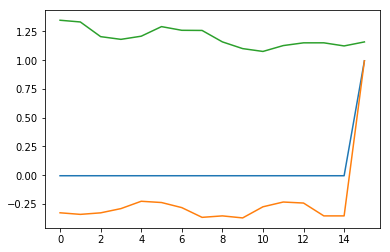

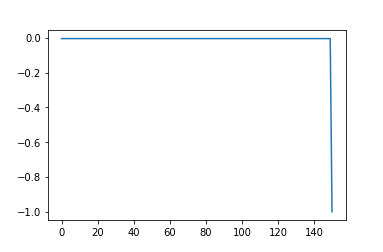

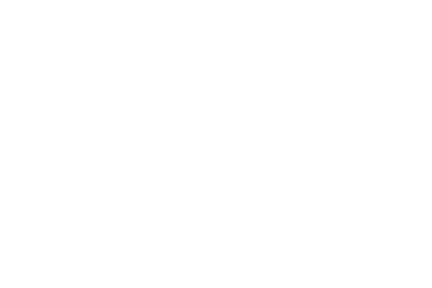

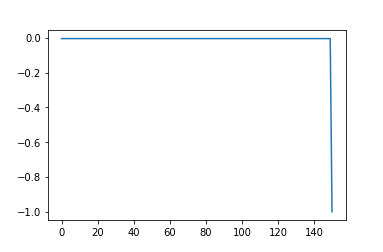

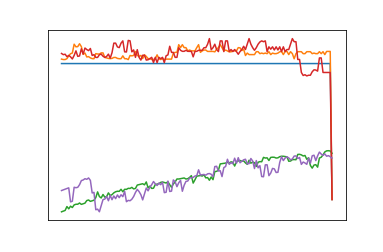

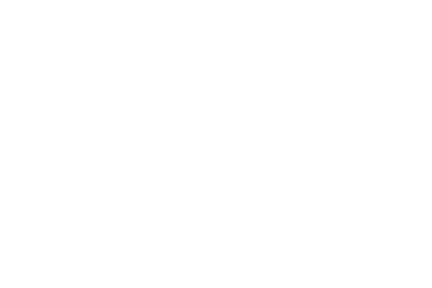

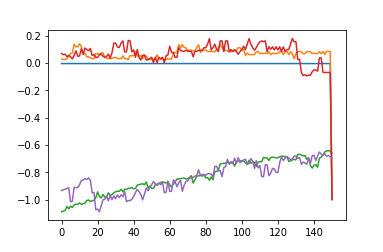

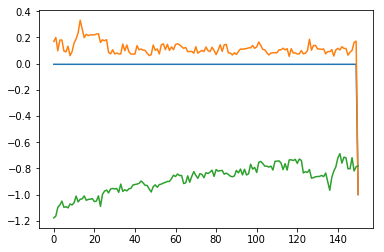

KeyboardInterrupt: 

In [9]:
coord = tf.train.Coordinator()
with tf.device("/cpu:0"):
    # Global Network
    global_step = tf.Variable(0, trainable=False, name='global_step')
    global_step_next = tf.assign_add(global_step, 1)
    global_ac = Network(in_size=in_size,
                        action_size=action_space,
                        scope=global_scope,
                        sess=sess,
                        global_step=global_step)

    # Local workers
    workers = []
    # loop for each workers

    for idx in tqdm(range(nenv), ncols=65, desc="Process Initiate"):
        name = 'W_%i' % idx
        workers.append(Environment(name, global_ac, sess, global_step=global_step, coord=coord))
    saver = tf.train.Saver(max_to_keep=3)
    writer = tf.summary.FileWriter(LOG_PATH, sess.graph)

    
ckpt = tf.train.get_checkpoint_state(MODEL_PATH)
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    print("Initialized Variables")
    

worker_threads = []
global_episodes = sess.run(global_step)

# Summarize
for var in tf.trainable_variables(scope=global_scope):
    tf.summary.histogram(var.name, var)
merged_summary_op = tf.summary.merge_all()

for worker in workers:
    job = lambda: worker.run(saver, writer)
    t = threading.Thread(target=job)
    t.start()
    worker_threads.append(t)
coord.join(worker_threads)
